<a href="https://colab.research.google.com/github/CarlosMendez1997Sei/WETSAT_v2/blob/main/2_Modelling_WETSAT_Google_Colab/Wetsat_Geoprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

						                           Google Colaboratory
						                              PostgreSQL
						                                GitHub	     
						Wetlands flooding extent and trends using SATellite data and Machine Learning WETSAT
													Code Developed by
													 Carlos Mendez
												  Sebastian Palomino
													Camilo Sanabria                     

# Install packages and libraries used in WETSAT

In [23]:
'''
###################################### Artificial Intelligence Frameworks #####################################################
# Geospatial Artificial Intelligence (GeoAI)
%pip install geoai-py
# scikit-learn Framework
!pip install scikit-learn
# Tensorflow Framework
!pip install tensorflow
# Keras Framework
!pip install Keras
# PyTorch Framework
!pip torch torchvision
###################################### Data, Geoprocessing and Graphics libraries #####################################################
!pip install rasterio
!pip install matplotlib
!pip install numpy
'''

'\n###################################### Artificial Intelligence Frameworks #####################################################\n# Geospatial Artificial Intelligence (GeoAI)\n%pip install geoai-py\n# scikit-learn Framework\n!pip install scikit-learn\n# Tensorflow Framework\n!pip install tensorflow\n# Keras Framework\n!pip install Keras\n# PyTorch Framework\n!pip torch torchvision\n###################################### Data, Geoprocessing and Graphics libraries #####################################################\n!pip install rasterio\n!pip install matplotlib\n!pip install numpy\n'

# Import libraries and packages

In [24]:
import geoai
import tensorflow
import keras
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import rasterio
from rasterio.features import rasterize
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import os

# Clone Repository from WETSAT [GitHub](https://github.com/sei-latam/WETSAT_v2)

In [3]:
!git clone https://github.com/sei-latam/WETSAT_v2.git

Cloning into 'WETSAT_v2'...
remote: Enumerating objects: 585, done.
remote: Counting objects: 100% (16/16), done.
remote: Compressing objects: 100% (11/11), done.
remote: Total 585 (delta 11), reused 7 (delta 5), pack-reused 569 (from 3)
Receiving objects: 100% (585/585), 1.41 GiB | 20.92 MiB/s, done.
Resolving deltas: 100% (66/66), done.
Updating files: 100% (246/246), done.


# Import S1 gamma_dB (VH-VV polarization)

In [33]:
vh_path = "/content/WETSAT_v2/0_Original_Files/aoi1/aoi1/gamma_dB/VH_gamma_dB/"
vv_path = "/content/WETSAT_v2/0_Original_Files/aoi1/aoi1/gamma_dB/VV_gamma_dB/"

System recognized 29 images VH polarization with size (1121, 967) each one.
System recognized 29 images VV polarization with size (1121, 967) each one.


Text(0.5, 1.0, 'First image of VH')

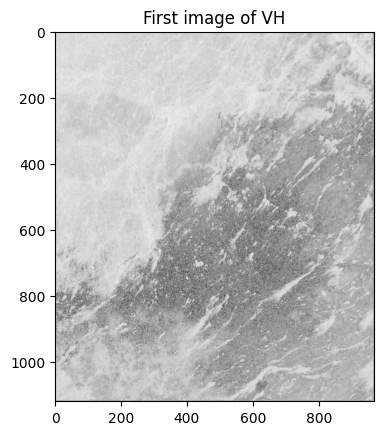

In [34]:


# Create a function to load images in a folder
def load_images(folder_path): # Create a request 'folder path' as a directory of data
    images = [] # Create a temporal empty array of images
    for file in sorted(os.listdir(folder_path)): # Call the folfer 'path'
        if file.endswith(".tif"): # Search images ending in .tif
            with rasterio.open(os.path.join(folder_path, file)) as src: # Open the images located in folder path
                images.append(src.read(1))
    return np.array(images) # Return array of images

# Call function and load images
vh_images = load_images(vh_path)
vv_images = load_images(vv_path)

print(f"System recognized {vh_images.shape[0]} images VH polarization with size {vh_images.shape[1:]} each one.")
print(f"System recognized {vv_images.shape[0]} images VV polarization with size {vv_images.shape[1:]} each one.")
assert vh_images.shape == vv_images.shape, "The dimensions and size of VH-VV polarizations are equal"

# Combine the VH-VV polarization with the same size and dimensions
X = np.stack([vh_images, vv_images], axis=-1)  # (n_images)

# Plot first image of VF
base_image = vh_images[0]

# Mostrar imagen Sentinel-1
plt.imshow(base_image, cmap='gray')
plt.title("First image of VH")

# Import points (.shp) with labels and marks

In [12]:
# Open shapefile folder
shapefile_path = "/content/WETSAT_v2/0_Original_Files/aoi1/aoi1/points_AOI1_Mask/points_AOI1.shp"
# Import geopandas and read .shp
gdf = gpd.read_file(shapefile_path)
# Get coordinates of .shp
coords = [(geom.centroid.x, geom.centroid.y) for geom in gdf.geometry]
# Get values of the column "gridcode"
labels = gdf["gridcode"].values
# Print values
print(f"The marks and labels found in .shp are: {labels}")

The marks and labels found in .shp are: [26 22 26 22 22 24 22]


# Create marks and labels using rasterize (convert vector to raster)

Rasterization complete with Shape: (1121, 967)


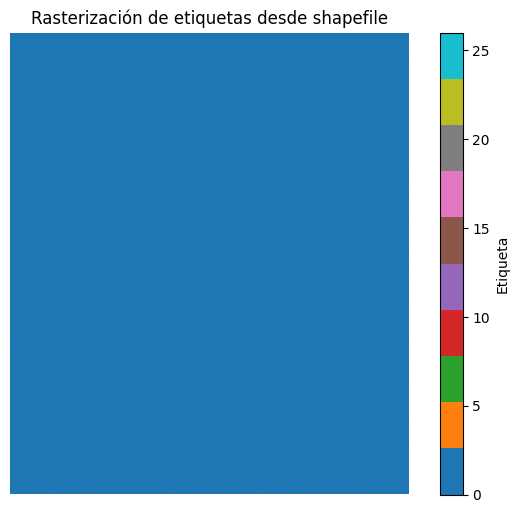

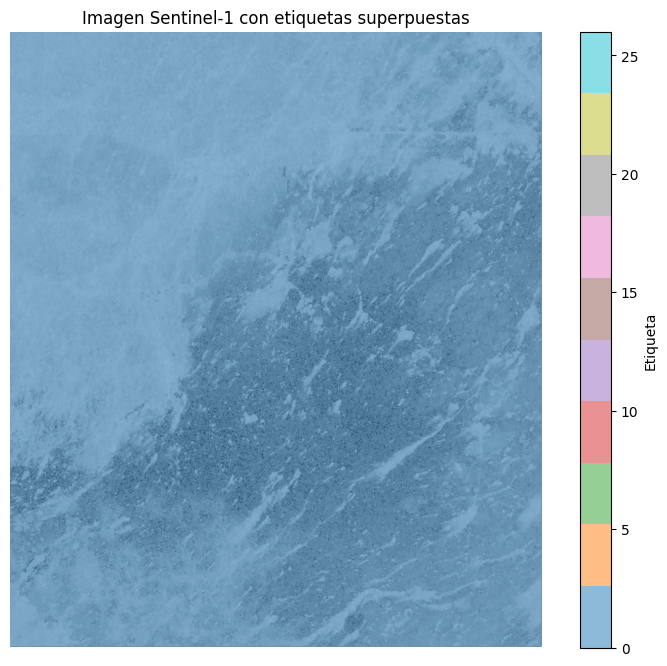

In [30]:
# Verification of System Reference Coordinates (.SRC) between VH-VV
with rasterio.open(os.path.join(vh_path, os.listdir(vh_path)[0])) as src:
    transform = src.transform
    raster_crs = src.crs

# Verify the .SRC with of rasters with the .shp named "gdf"
gdf = gdf.to_crs(raster_crs)

# Create a list between geometry and labels
shapes = [(geom, label) for geom, label in zip(gdf.geometry, gdf["gridcode"])]

# Rasterize the labels
raster_labels = rasterize(
    shapes,
    out_shape=(X.shape[1], X.shape[2]),  # height and width
    transform=transform,
    fill=0,
    dtype="int32"
)

print("Rasterization complete with Shape:", raster_labels.shape)

import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.imshow(raster_labels, cmap='tab10')  # Puedes cambiar el colormap según tus etiquetas
plt.title("Rasterización de etiquetas desde shapefile")
plt.colorbar(label="Etiqueta")
plt.axis('off')
plt.show()


import matplotlib.pyplot as plt

# Seleccionar una imagen Sentinel-1 (por ejemplo, la primera VH)
base_image = vh_images[0]

plt.figure(figsize=(10, 8))

# Mostrar imagen base en escala de grises
plt.imshow(base_image, cmap='gray')
plt.title("Imagen Sentinel-1 con etiquetas superpuestas")

# Superponer el raster de etiquetas con transparencia
plt.imshow(raster_labels, cmap='tab10', alpha=0.5)  # alpha controla la transparencia

# Añadir barra de color para etiquetas
plt.colorbar(label="Etiqueta")

plt.axis('off')
plt.show()

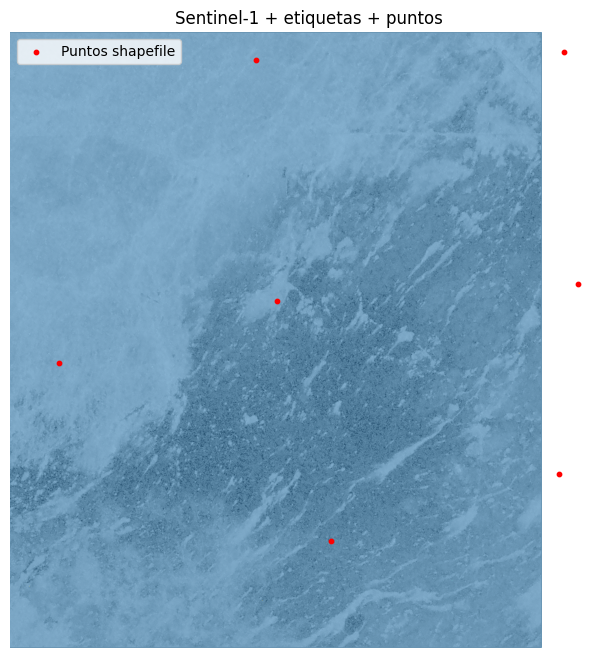

In [28]:
# Obtener el CRS de la imagen Sentinel-1
with rasterio.open(os.path.join(vh_path, os.listdir(vh_path)[0])) as src:
    raster_crs = src.crs

# Reproyectar el shapefile al CRS de la imagen
gdf = gdf.to_crs(raster_crs)



# Coordenadas de los puntos
x_coords = gdf.geometry.x
y_coords = gdf.geometry.y

plt.figure(figsize=(10, 8))



# Superponer etiquetas rasterizadas
plt.imshow(raster_labels, cmap='tab10', alpha=0.5)

# Superponer puntos del shapefile
plt.scatter(
    *rasterio.transform.rowcol(transform, x_coords.values, y_coords.values),
    color='red', s=10, label='Puntos shapefile'
)

plt.legend()
plt.axis('off')
plt.show()


In [25]:
X_train = []
y_train = []

for i in range(X.shape[0]):
    img = X[i]  # (alto, ancho, 2)
    img_flat = img.reshape(-1, 2)
    labels_flat = raster_labels.flatten()
    mask = labels_flat > 0

    X_train.append(img_flat[mask])
    y_train.append(labels_flat[mask])

# Concatenar todos los datos
X_train = np.concatenate(X_train, axis=0)
y_train = np.concatenate(y_train, axis=0)

print(f"Total muestras: {X_train.shape[0]}")
print(f"Total muestras: {y_train.shape[0]}")

Total muestras: 203
Total muestras: 203


In [21]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

X_tr, X_te, y_tr, y_te = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_tr, y_tr)
print("Accuracy RF:", rf.score(X_te, y_te))

Accuracy RF: 0.7073170731707317


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

model_tf = Sequential([
    Dense(64, activation='relu', input_shape=(2,)),
    Dense(64, activation='relu'),
    Dense(len(set(y_train)), activation='softmax')
])

model_tf.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model_tf.fit(X_tr, y_tr, epochs=10, validation_data=(X_te, y_te))

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

class SimpleNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc = nn.Sequential(
            nn.Linear(2, 64),
            nn.ReLU(),
            nn.Linear(64, len(set(y_train)))
        )

model_pt = SimpleNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_pt.parameters(), lr=0.001)

X_tr_tensor = torch.tensor(X_tr, dtype=torch.float32)
y_tr_tensor = torch.tensor(y_tr, dtype=torch.long)

for epoch in range(10):
    optimizer.zero_grad()
    outputs = model_pt(X_tr_tensor)
    loss = criterion(outputs, y_tr_tensor)
    loss.backward()
    optimizer.step()
    print(f"Epoch {epoch+1}, Loss: {loss.item():.4f}")

deseo desarrollar un programa y código en Google Colab que utilice los frameworks Tensorflow, Keras, scikit-learn y Pytorch, para leer imágenes Sentinel-1 de un github, con carpetas separadas (VH y VV), luego utilizar las diferentes etiquetas de datos proveniente de un archivo de puntos shapefile (alojado en GitHub). Finalmente, usar los modelos para pronosticar o identificar posibles etiquetas en las imágenes S1.